# 1. CNN 기반 베이스 모델
- 다른 모델과의 비교를 위한 기본 모델

## 1-1. Set-up

### 패키지 import

In [2]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 변수 설정

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)
print(TRAIN_PATH)
print(VAL_PATH)
print(TEST_PATH)

/aiffel/aiffel
/aiffel/aiffel/chest_xray/data/train/*/*
/aiffel/aiffel/chest_xray/data/val/*/*
/aiffel/aiffel/chest_xray/data/test/*/*


## 1-2. 데이터 준비하기

### 데이터로 사용될 파일 이름 가져오기

In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# 파일 이름 10개만 출력해서 확인하기
for i in range(10):
    print(train_filenames[i])

/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0487-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0987-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0700-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0674-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0504-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1303-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0530-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1174-0001.jpeg
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0450-0001.jpeg


### 검증용 이미지가 너무 적어서 train, val 합친 후 80:20 비율로 다시 나누기

In [6]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### 파일 경로 확인

In [7]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


### train 데이터 중에서 정상 이미지와 폐렴 이미지 개수 확인

In [8]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


### tf.data 인스턴스 생성하기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
print(train_list_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 정답용 label 생성과 이미지 전처리를 위해 필요한 함수 정의

In [11]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [12]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### train, val 데이터셋 준비하기(정답용 label 포함)

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### test 데이터셋 준비하기(정답용 label 포함)

In [15]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### tf.data 파이프라인 준비하기

In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 미니 배치 데이터 시각화해서 확인하기

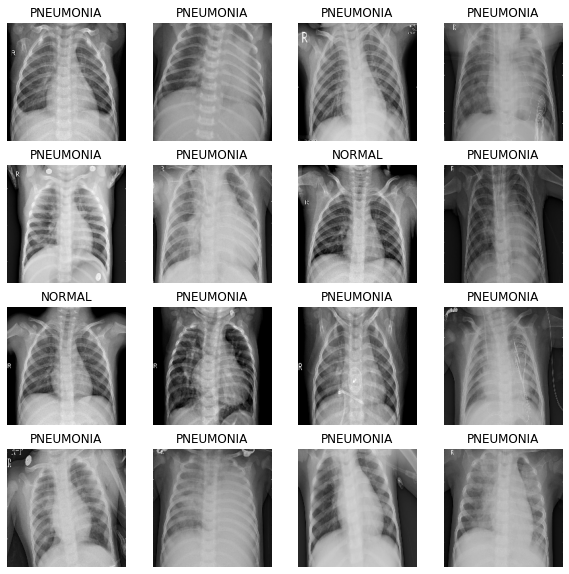

In [19]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 1-3. CNN 모델링

### 모델 정의

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 불균형 문제 처리

In [23]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 생성, 컴파일, 훈련

In [24]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 200ms/step - loss: 0.4382 - accuracy: 0.7888 - precision: 0.9445 - recall: 0.7609 - val_loss: 0.6671 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2299 - accuracy: 0.9071 - precision: 0.9742 - recall: 0.8990 - val_loss: 1.0447 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 51s 197ms/step - loss: 0.2023 - accuracy: 0.9239 - precision: 0.9787 - recall: 0.9177 - val_loss: 0.1894 - val_accuracy: 0.9144 - val_precision: 0.8973 - val_recall: 0.9974
Epoch 4/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1999 - accuracy: 0.9248 - precision: 0.9761 - recall: 0.9215 - val_loss: 0.2998 - val_accuracy: 0.8885 - val_precision: 0.9954 - val_recall: 0.8519
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1931 - accura

## 1-4. 결과 확인

### 그래프로 확인하기

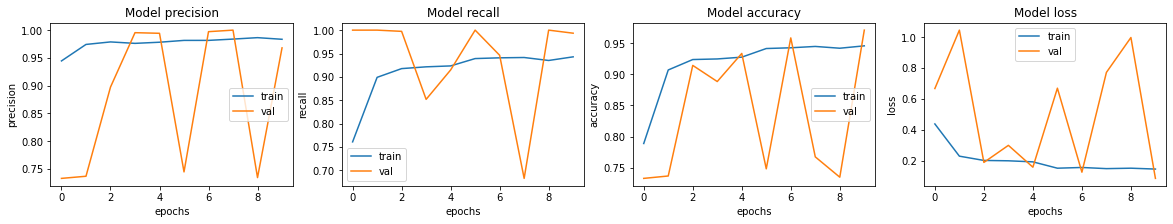

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 116ms/step - loss: 1.0212 - accuracy: 0.7115 - precision: 0.6842 - recall: 1.0000
Loss: 1.0212219953536987,
Accuracy: 0.7115384340286255,
Precision: 0.6842105388641357,
Recall: 1.0


# 2. 데이터 Augmentation 적용 모델
- 데이터 증강을 적용하면 결과가 어떻게 달라질지 비교해 보기. 

## 2-1. 데이터 Augmentation 처리

### 데이터 Augmentation 적용해 train, val 데이터셋 준비하기

In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomFlip("vertical"),
#         tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomZoom(0.1),
#     ]
# )

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
#     ds = data_augmentation(ds)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 미니 배치 데이터 시각화해서 확인하기

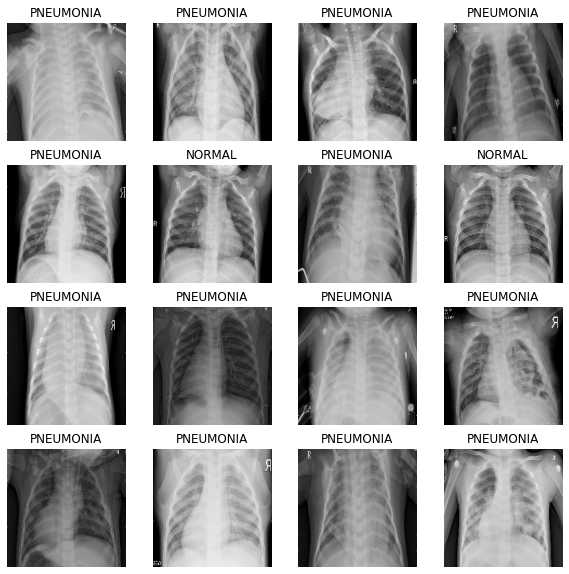

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 2-2. CNN 모델링

### 모델 정의

In [23]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [24]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [25]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 불균형 문제 처리

In [26]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 생성, 컴파일, 훈련

In [27]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 66s 203ms/step - loss: 0.4033 - accuracy: 0.8118 - precision: 0.9500 - recall: 0.7885 - val_loss: 0.7712 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 196ms/step - loss: 0.2331 - accuracy: 0.9045 - precision: 0.9695 - recall: 0.8999 - val_loss: 1.2602 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 201ms/step - loss: 0.2286 - accuracy: 0.9112 - precision: 0.9754 - recall: 0.9036 - val_loss: 0.9318 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1738 - accuracy: 0.9308 - precision: 0.9776 - recall: 0.9283 - val_loss: 0.3271 - val_accuracy: 0.8923 - val_precision: 0.9985 - val_recall: 0.8545
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1807 - accura

## 2-3. 결과 확인

### 그래프로 확인하기

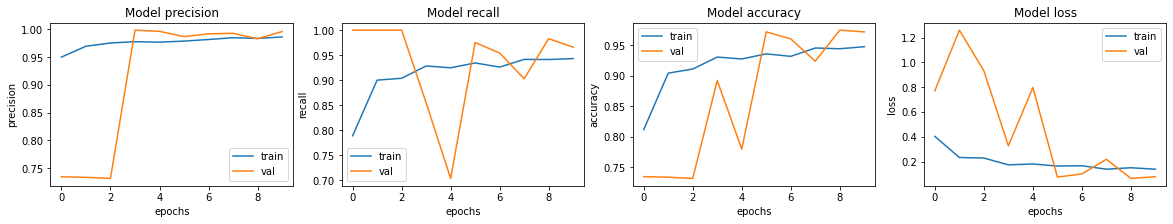

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가

In [30]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 113ms/step - loss: 0.5313 - accuracy: 0.8157 - precision: 0.7859 - recall: 0.9692
Loss: 0.5312644243240356,
Accuracy: 0.8157051205635071,
Precision: 0.7858628034591675,
Recall: 0.9692307710647583


# 3. 구조 변경 모델
- convolution 블럭에서 SeparableConv2D 레이어를 하나 더 추가하면 결과가 어떻게 될지 비교해 보기. 

In [31]:
# 먼저, 바로 앞에 진행했던 모델의 구조를 확인해보자. 
# 마지막 feature map 사이즈가 이미 (5, 5)로 충분히 작은 상태여서 블럭 단위로 더 쌓기는 어려운 상태임. 
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

## 3-1. train, val 데이터셋 준비하기
- 비교를 위해 데이터 증강은 없이 준비

### train, val 데이터셋 준비하기(정답용 label 포함)

In [41]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [42]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### tf.data 파이프라인 준비하기

In [43]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomFlip("vertical"),
#         tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomZoom(0.1),
#     ]
# )

def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = data_augmentation(ds)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3-2. CNN 모델링 구조 변경하기

### 모델 정의
- convolution 블럭 내에 SeparableConv2D 레이어를 하나 더 추가해서 비교하기

In [44]:
# convolution 블럭 내에 SeparableConv2D 레이어를 하나 더 추가
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [45]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [46]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 불균형 문제 처리

In [47]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 생성, 컴파일, 훈련

In [48]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [49]:
# 파라미터 수를 비교해 보자. 
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 45, 45, 32)        3504      
_________________________________________________________________
sequential_17 (Sequential)   (None, 22, 22, 64)        12128     
_________________________________________________________________
sequential_18 (Sequential)   (None, 11, 11, 128)       44736     
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 11, 128)     

In [50]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 62s 202ms/step - loss: 0.8798 - accuracy: 0.4799 - precision: 0.7302 - recall: 0.4773 - val_loss: 0.6427 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 200ms/step - loss: 0.7741 - accuracy: 0.5074 - precision: 0.7529 - recall: 0.5037 - val_loss: 0.6781 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 201ms/step - loss: 0.7457 - accuracy: 0.4890 - precision: 0.7352 - recall: 0.4908 - val_loss: 0.6142 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 52s 201ms/step - loss: 0.7273 - accuracy: 0.4966 - precision: 0.7392 - recall: 0.4998 - val_loss: 0.6788 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 53s 204ms/step - loss: 0.7058 - accura

## 3-3. 결과 확인

### 그래프로 확인하기

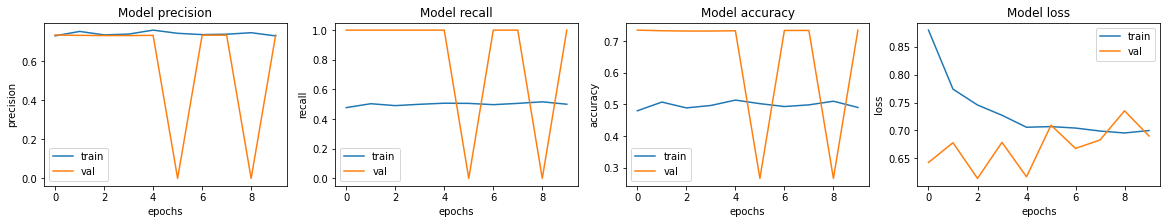

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가

In [52]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step - loss: 0.6916 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6915580034255981,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


### 모델 시각화하기

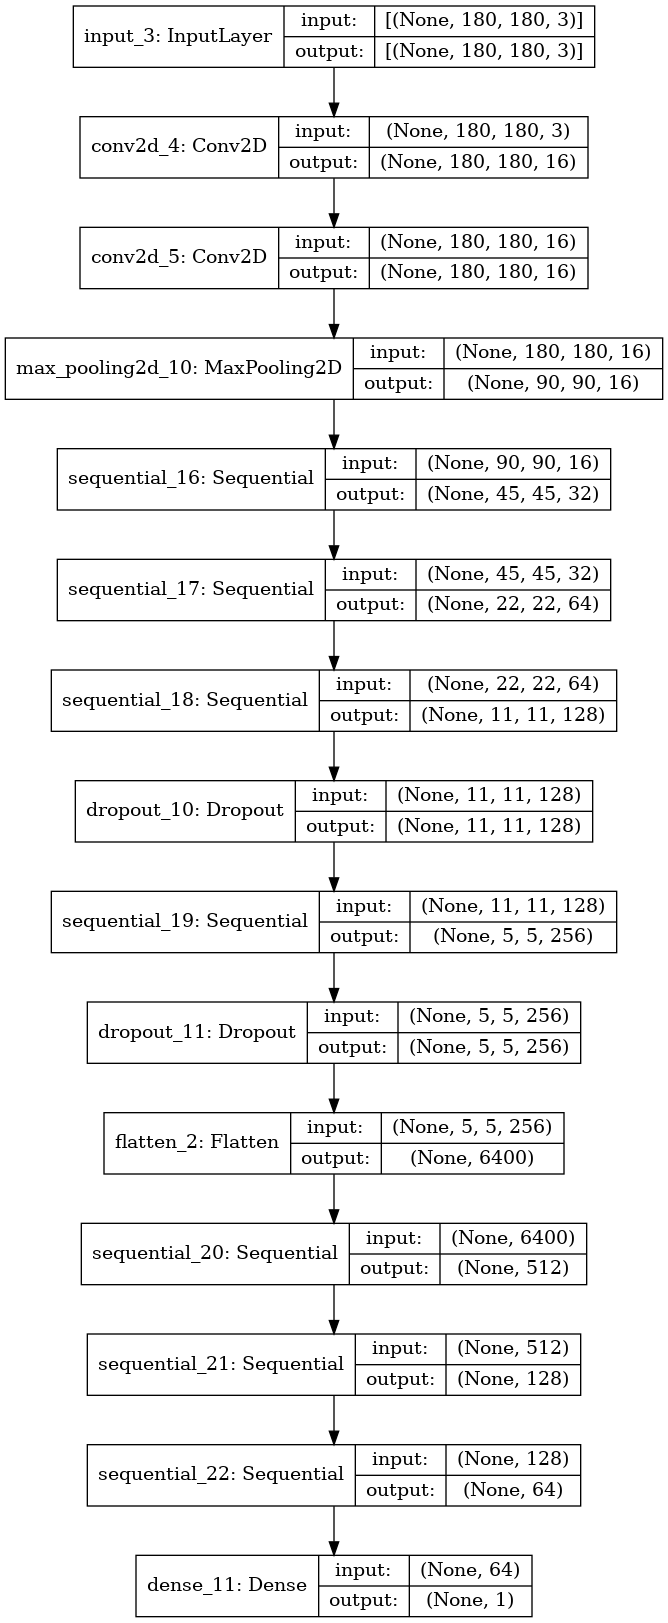

In [53]:
from tensorflow.keras.utils import plot_model # 모델 시각화

plot_model(model, show_shapes=True, to_file='deep_convolution_model.png')

# 4. ResNet 모델

## 4-1. train, val 데이터셋 준비하기
- 비교를 위해 데이터 증강은 없이 준비

### train, val 데이터셋 준비하기(정답용 label 포함)

In [54]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [55]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### tf.data 파이프라인 준비하기

In [56]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomFlip("vertical"),
#         tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomZoom(0.1),
#     ]
# )

def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = data_augmentation(ds)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 4-2. ResNet 모델링

### 모델 정의
- 함수형 API 방식으로 변경해서 정의

In [57]:
# 함수형 API 방식으로 작성
def residual_block(input_layer, filters):
    merge_input = input_layer

    # if문에서는 채널 사이즈가 동일한지 확인하고, 만일 동일하지 않다면 1x1 convolution을 통해서 채널 사이즈를 맞춰 준다.
    if input_layer.shape[-1] != filters:
        merge_input = tf.keras.layers.Conv2D(filters, (1,1), padding='same', activation='relu')(input_layer) # filters로 채널 사이즈를 맞춰 준다.
    # Conv2D layer
    conv1 = tf.keras.layers.SeparableConv2D(filters, (3,3), padding='same', activation='relu')(input_layer)
    # Conv2D layer
    conv2 = tf.keras.layers.SeparableConv2D(filters, (3,3), padding='same', activation='linear')(conv1)

    # Add를 통해서 skip connection을 구현하는 부분
    out_layer = tf.keras.layers.Add()([conv2, merge_input])
    out_layer = tf.keras.layers.Activation('relu')(out_layer)
    
    # BatchNormalization, MaxPool2D 추가
    out_layer = tf.keras.layers.BatchNormalization()(out_layer)
    out_layer = tf.keras.layers.MaxPool2D()(out_layer)

    return out_layer

In [58]:
# 함수형 API 방식으로 변경해서 작성
def dense_block(input_layer, units, dropout_rate):
    out_layer = tf.keras.layers.Dense(units, activation='relu')(input_layer)
    out_layer = tf.keras.layers.BatchNormalization()(out_layer)
    out_layer = tf.keras.layers.Dropout(dropout_rate)(out_layer)
    
    return out_layer

In [59]:
# 함수형 API 방식으로 변경해서 작성
def build_model():
    input = tf.keras.layers.Input(shape=(180, 180, 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = residual_block(x, 32)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = residual_block(x, 256)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # 모델 생성
    model = tf.keras.models.Model(inputs=input, outputs=output)
        
    return model

### 데이터 불균형 문제 처리

In [60]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


### 모델 생성, 컴파일, 훈련

In [61]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [66]:
# 파라미터 수를 비교해 보자. 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 180, 180, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 180, 180, 16) 2320        conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 90, 90, 16)   0           conv2d_7[0][0]                   
______________________________________________________________________________________________

In [62]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 62s 198ms/step - loss: 0.3961 - accuracy: 0.8101 - precision: 0.9544 - recall: 0.7820 - val_loss: 3.2414 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 196ms/step - loss: 0.2381 - accuracy: 0.9021 - precision: 0.9691 - recall: 0.8971 - val_loss: 1.0510 - val_accuracy: 0.7327 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 198ms/step - loss: 0.2193 - accuracy: 0.9162 - precision: 0.9723 - recall: 0.9136 - val_loss: 0.7259 - val_accuracy: 0.7365 - val_precision: 0.7358 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 51s 197ms/step - loss: 0.1988 - accuracy: 0.9210 - precision: 0.9783 - recall: 0.9140 - val_loss: 0.2183 - val_accuracy: 0.9202 - val_precision: 0.9956 - val_recall: 0.8950
Epoch 5/10
261/261 [==============================] - 51s 196ms/step - loss: 0.1857 - accura

## 4-3. 결과 확인

### 그래프로 확인하기

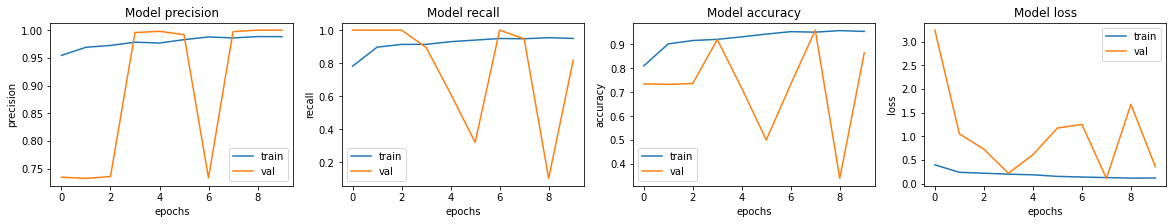

In [63]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 모델 평가

In [64]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 111ms/step - loss: 0.3411 - accuracy: 0.8750 - precision: 0.9021 - recall: 0.8974
Loss: 0.34112152457237244,
Accuracy: 0.875,
Precision: 0.9020618796348572,
Recall: 0.8974359035491943


### 모델 시각화하기

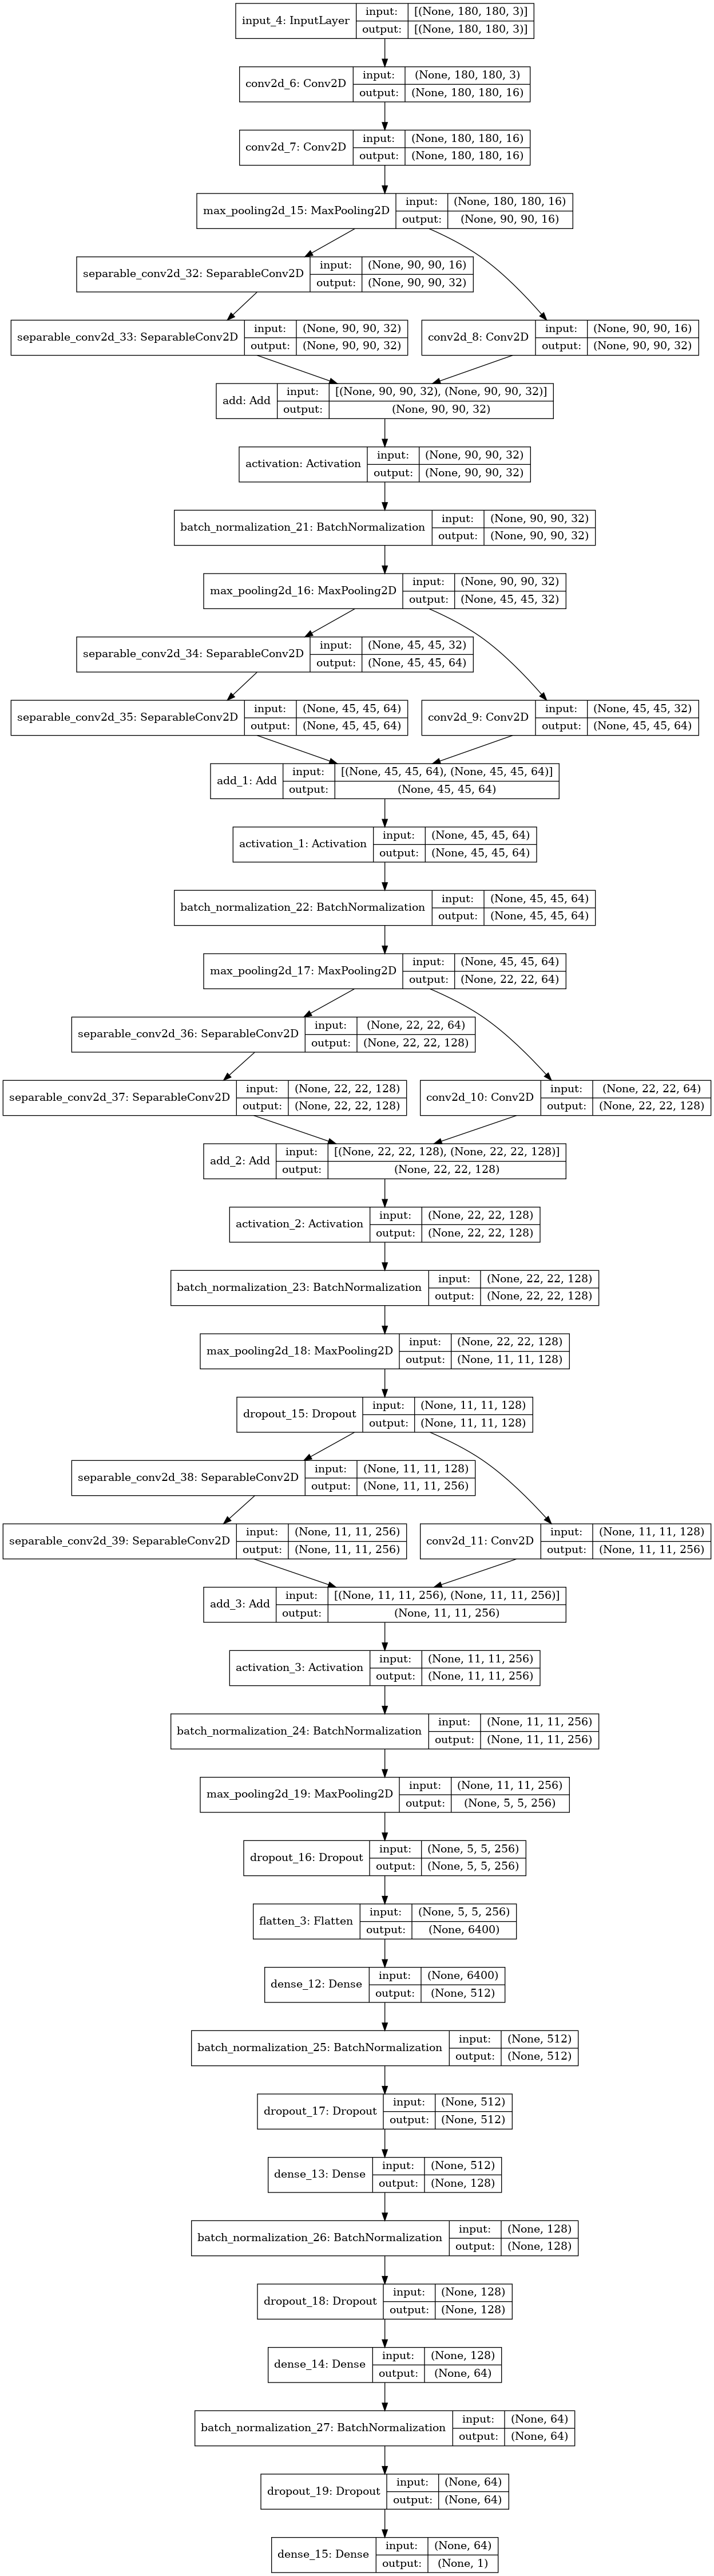

In [65]:
from tensorflow.keras.utils import plot_model # 모델 시각화

plot_model(model, show_shapes=True, to_file='resnet_model.png')

# Summary
- 베이스 모델
    - 파라미터 수 : 3,496,801
    - Loss: 1.0212219953536987
    - Accuracy: 0.7115384340286255
    - Precision: 0.6842105388641357
    - Recall: 1.0
- 데이터 Augmentation 적용 모델
    - 파라미터 수 : 3,496,801
    - Loss: 0.5312644243240356
    - Accuracy: 0.8157051205635071
    - Precision: 0.7858628034591675
    - Recall: 0.9692307710647583
- 구조 변경 모델(Conv 레이어 추가, 데이터 Augmentation 없음.)
    - 파라미터 수 : 3,588,641
    - Loss: 0.6915580034255981
    - Accuracy: 0.625
    - Precision: 0.625
    - Recall: 1.0
- ResNet 모델(데이터 Augmentation 없음)
    - 파라미터 수 : 3,540,801
    - Loss: 0.34112152457237244
    - Accuracy: 0.875
    - Precision: 0.9020618796348572
    - Recall: 0.8974359035491943<br>
<br>
[결론]
- Loss 기준으로는 ResNet 모델이 가장 좋은 결과를 보여줌. 
- 정확도 기준으로도 ResNet 모델이 가장 좋은 결과를 보여줌. (87.5%)
- 정밀도 기준으로도 ResNet 모델이 가장 좋은 결과를 보여줌. (90%)
- Recall 기준으로는 베이스 모델과 구조 변경 모델이 가장 좋은 결과를 보여줌.(1.0) 하지만, 두 모델 모두 정확도와 정밀도 모두 낮은 것으로 봐서 Recall 비율만 높지 오진율 역시 높을 것으로 보임. 
- 따라서, 종합적인 비율에 있어서 가장 안정적인 모습을 보이는 모델은 ResNet 모델이라고 잠정 결론 내일 수 있을 것으로 보임. 

# 회고
- 모든 모델에서 검증 곡선이 부드럽게 나타나지 않고 변동폭이 크게 오르락 내리락 하는 모습을 보여주고 있어서 이유를 좀 더 규명할 필요가 있음. 
- 구조 변경 모델에서 convolution 레이어를 추가하는 것 외에, epoch 또는 batch size 등의 하이퍼파라미터를 조정해 보지 못한 점은 아쉬움. 
- 하지만, 실제 의료 데이터를 기준으로 실제 동작하는 모델을 구현해 볼 수 있어서 많은 도움이 되었음. 